Big Data And Society: Lab 3
=====


# Data Scraping

Lets make sure that we don't get tweets plotted more than once. How would you make sure to only plot unique tweets? We can maybe:

* Construct a list with unique id's
* Only add the tweets to the `numpy.array` if the tweet doesn't exist in the list.

### Problem Set - Extend What you Learned

Now that you know how to scrape data let's extend the exercise a little so you can show us what you know. This time you will set up the scraper to get data around MIT and scrap data for 15 minutes and visualize. Think about what you would need to change to do that. 

Once you have the new json file of Boston tweets you should make a new array so that you can make a new scatter plot of your Boston tweets. When you make this new array you should get at least two different attributes returned by the Twitter api. One of them should be the tweet id. Make sure you remove and duplicate tweets (if any). Plot the tweets with different colors (use lat/long to determine the colors) using the scatter plot tool. Then save the data to a CSV.

Make sure you get your own Twitter Key.

#### Deliverables

**1** - Collect Tweets from Boston for 15 min. Note how you set the time in the above example, it was in seconds. How would you do that here? 

**2** - Plot your tweets using matplotlib.

**3** - Change colors based on lat/long position.

**4** - Save your array CSV file. We will be checking this CSV file for duplicates. So clean your file.  

### What to Give Us on Stellar 

1 - Iphython notebook of your scrapper, which includes your scattterplot.

2 - Your final CSV file. 

### Bonus # 1

Bonus  -- Do the orginally planned assignment now titled Bonus. If you do the whole thing you get a free homework assignment. If  you do parts of it you will get points to future assignments. 


In [1]:
import json
import time
import threading

from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import t_key, t_secret

In [2]:
# Assigns the keys to the variables
APP_KEY = t_key
APP_SECRET = t_secret

''' Fetches tweets with a given query at a given lat-long.'''
def get_tweets( latlong=None ):
    # Creates a Twithon object with the given keys
    twitter = Twython( APP_KEY, APP_SECRET )
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = twitter.search( geocode=','.join([ str(x) for x in latlong ]) + ',15km', result_type='recent', count=10000)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

In [3]:
#GPS Coordinates of 77 Massachusetts Ave., Cambridge
latlong_MIT = [42.359254,-71.093134]

def get_lots_of_tweets_MIT(latlong):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # Will collect Tweets for 15 minutes, or 900 seconds total
    total_time = 900
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 30 
    while remaining_seconds >= 0:
        added = 0
        # We hit the Twitter API
        new_tweets = get_tweets(latlong)
        # We parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets and tweet['coordinates'] != None:
                properties = {}
                properties['lat'] = tweet['coordinates']['coordinates'][1]
                properties['lon'] = tweet['coordinates']['coordinates'][0]
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['user_location'] = tweet['user']['location']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[tid] = properties
                added += 1
                
        print "At %d seconds, added %d new tweets, for a total of %d" % (total_time - remaining_seconds, added, len(all_tweets))
        # We wait 30 seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    # We return the final dictionary
    return all_tweets

def run(): 
    try:
        t = get_lots_of_tweets_MIT(latlong_MIT)
        # We name every file with the current time
        timestr = time.strftime("%Y%m%d-%H%M%S")
        # We write a new JSON into the target path
        with open( 'data/%stweets.json' %(timestr), 'w' ) as f:
            f.write(json.dumps(t))              
    except:
        pass
    
run()

At 0 seconds, added 95 new tweets, for a total of 95
At 30 seconds, added 2 new tweets, for a total of 97
At 60 seconds, added 2 new tweets, for a total of 99
At 90 seconds, added 1 new tweets, for a total of 100
At 120 seconds, added 4 new tweets, for a total of 104
At 150 seconds, added 4 new tweets, for a total of 108
At 180 seconds, added 1 new tweets, for a total of 109
At 210 seconds, added 1 new tweets, for a total of 110
At 240 seconds, added 1 new tweets, for a total of 111
At 270 seconds, added 3 new tweets, for a total of 114
At 300 seconds, added 3 new tweets, for a total of 117
At 330 seconds, added 2 new tweets, for a total of 119
At 360 seconds, added 4 new tweets, for a total of 123
At 390 seconds, added 5 new tweets, for a total of 128
At 420 seconds, added 2 new tweets, for a total of 130
At 450 seconds, added 1 new tweets, for a total of 131
At 480 seconds, added 3 new tweets, for a total of 134
At 510 seconds, added 3 new tweets, for a total of 137
At 540 seconds, a

In [4]:
#I will later color points on the scatterplot by proximity of tweet generation location to 77 Mass Ave.\
#Hence I need to be able to calculate distance between two sets of GPS coordinates. \
#The haversine function code below is taken directly from \
#http://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance (km) between two points 
    on the earth 
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [5]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Get the file names from a given directory
file_dir = 'data' 
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# Initialize some lists to store the points, and the ids of the tweets
ids = []
all_pts = []
# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file)
    # Open the JSON
    with open(full_dir) as f:
        data = f.read()
        # Load the JSON as a dict
        dict = json.loads(data)
        # Only add the unique tweets to the list
        if not isinstance(dict, list):
            for key, val in dict.iteritems():
                if key not in ids:
                    ids.append(key)
                    lat = val['lat']
                    lon = val['lon']
                    t_id = val['tweet_id']
                    time = val['time']
                    #distance = distance of tweet generation location from 77 Mass Ave
                    distance = haversine(float(lon), float(lat), -71.093134, 42.359254)
                    all_pts.append([t_id, lat, lon, time, distance])

pts = np.array(all_pts)
pts  

array([[u'704033430200143872', u'42.3585133', u'-71.0584124',
        u'Sun Feb 28 20:00:24 +0000 2016', u'2.85234108478'],
       [u'704033485141446656', u'42.35146382', u'-71.06063515',
        u'Sun Feb 28 20:00:37 +0000 2016', u'2.80567457847'],
       [u'704034542210969604', u'42.33657077', u'-71.10084321',
        u'Sun Feb 28 20:04:49 +0000 2016', u'2.59897841248'],
       [u'704029574271799297', u'42.36718484', u'-71.07652187',
        u'Sun Feb 28 19:45:05 +0000 2016', u'1.62395458987'],
       [u'704029199342784513', u'42.3584308', u'-71.0597732',
        u'Sun Feb 28 19:43:36 +0000 2016', u'2.74094031072'],
       [u'704034798554091520', u'42.2528772', u'-71.0022705',
        u'Sun Feb 28 20:05:50 +0000 2016', u'13.9822260095'],
       [u'704030576307638272', u'42.3584308', u'-71.0597732',
        u'Sun Feb 28 19:49:04 +0000 2016', u'2.74094031072'],
       [u'704029792358649856', u'42.4691783', u'-71.0255726',
        u'Sun Feb 28 19:45:57 +0000 2016', u'13.4141133395'],
  

In [6]:
def colors(data):
    '''
    data = a numpy array 
    '''
    data2 = data.astype(np.float)

    scaled = (data2 - data2.min())/data2.ptp()
    
    return plt.cm.RdYlBu(scaled)


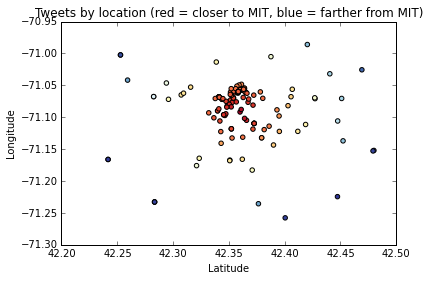

In [9]:
plt.scatter(pts[:,1], pts[:,2], c=colors(pts[:,4]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Tweets by location (red = closer to MIT, blue = farther from MIT)')
plt.show()

In [8]:
#write to csv

import csv

f = open('MIT Tweet Mining.csv','wb')
writer = csv.writer(f)
writer.writerow(['Tweet ID', 'Latitude', 'Longitude', 'time', 'distance from MIT (km)'])

p = 0
l = len(pts)
for p in range(len(pts)):
    writer.writerow((pts[p][0],pts[p][1],pts[p][2],pts[p][3],pts[p][4]))
    
f.close()